In [1]:
from skimage import io,color,filters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

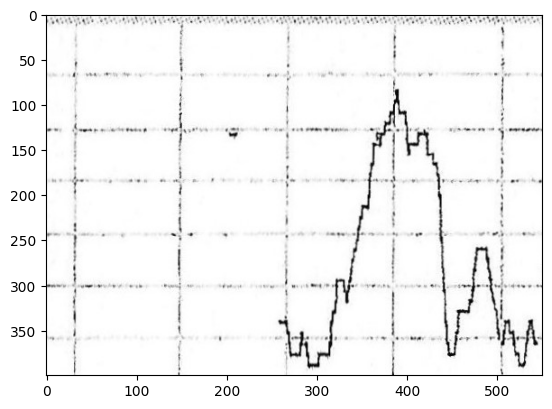

In [2]:
A=io.imread('./assets/final_1.jpeg')
A=A[700:1100,:550]
plt.imshow(A)
A_hsv=color.rgb2hsv(A)

In [3]:
def B_hsv(X):
    #Detect the blue point at the beginning of the signal
    t1=X[0]>=168/360
    t2=X[0]<=263/360
    t3=X[1]>=0.75
    t4=X[2]>=0.4
    
    return t1 and t2 and t3 and t4
def black_hsv(x):
    t1=x[2]<=0.15
    t2=x[1]<=0.25
    t3=x[2]<=0.7
    
    return t1 or (t2 and t3)

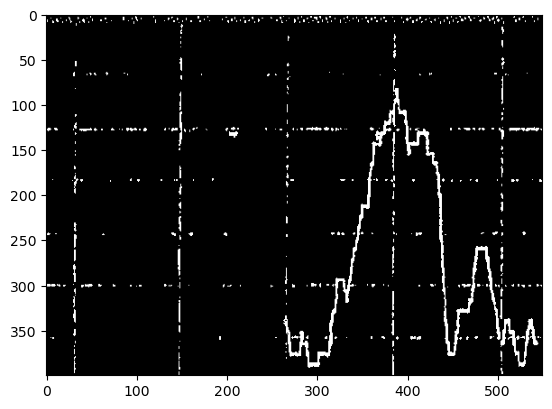

In [4]:
A_bin=np.apply_along_axis(black_hsv,-1,A_hsv)
plt.imshow(A_bin,cmap='gray')

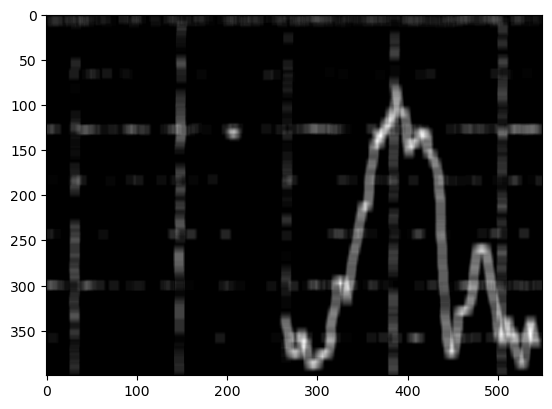

In [5]:
def countpoint(x,y,kernel=3):
    M,m=A_bin.shape
    lx=ly=kernel//2 
    rx=ry=kernel//2 +1
    if x-lx <0:
        lx=x
    if y-ly <0:
        ly=y
    if x+rx >M:
        rx=M-x
    if y+ry >m:
        ry=m-y
        
    w=A_bin[x-lx:x+rx,y-ly:y+ry]
    return np.sum(w)

D=np.zeros(A_bin.shape,int)
for i in range(A_bin.shape[0]):
    for j in range(A_bin.shape[1]):
        D[i,j]=countpoint(i,j,kernel=10)

plt.imshow(D,cmap='gray')        

In [6]:
def dist(x:int,window:tuple,dot:tuple):
    t=[x//window[1],x%window[1]]
    max_dist=((window[0]-dot[0])**2+(window[1]-dot[1])**2)**0.5
    return ((t[0]-dot[0])**2+(t[1]-dot[1])**2)**0.5

def S(x:int,window:tuple,dot:tuple):
    t=[x//window[1],x%window[1]]
   
    return np.sign(t[1]-dot[1])

def topsis(df,casos,pesos):
    casos/=np.sum(df**2)
    df/=np.sum(df**2)
    df*=pesos
    casos*=pesos
    dp=np.sum((df-casos.loc[0])**2,axis=1)
    dn=np.sum((df-casos.loc[1])**2,axis=1)
    df['R']=dn/(dn+dp)
    df.sort_values('R',ascending=False,inplace=True)
    
    return df

def next_point(li,pointer,dot,PASSED):
    try:
        r=next(li)
        p=[pointer[0]+(r[0]-dot[0]),pointer[1]+(r[1]-dot[1])]
        while p in PASSED:
            r=next(li)
            p=[pointer[0]+(r[0]-dot[0]),pointer[1]+(r[1]-dot[1])]
            
    except StopIteration:
        print('No hay mas')
    finally:
        print(f'{pointer} to {p}')
        return p
        
        
        

In [7]:
%matplotlib notebook
plt.rcParams['animation.html']='jshtml'

#Starting Point
mask=np.apply_along_axis(B_hsv,-1,A_hsv)
x,y=np.where(mask)
center=[(max(x)+min(x))//2,(max(y)+min(y))//2]
R=list()


def pathing(A_hsv,center,kernel=51,pesos=[1/4,1/4,1/4,1/4],max_it=300):
    
    if not kernel%2:
        kernel+=1
    
    #IMG to path
    PATH=A_hsv.copy().astype('uint8')
    PATH[:,:]=[255,255,255]
    PATH[center[0],center[1]]=[255,0,0]
    fig=plt.figure()
    fig.show()
    pointer=center
    PASSED=[center]
    it=0
    
    W=np.zeros((max_it,len(pesos)))
    
    while it<max_it:
        
        #Ventana
        radio=kernel//2
        x1=pointer[0]-radio
        x2=pointer[0]+radio
        y1=pointer[1]+radio
        y2=pointer[1]-radio
        dot=[radio,radio]
        
        if x1<0:
            x1=0
            dot[0]=pointer[0]
        if y1<0:
            y1=0
            dot[1]=pointer[1]
        
        window=A_hsv[pointer[0]-kernel//2:pointer[0]+kernel//2,pointer[1]-kernel//2:pointer[1]+kernel//2].copy()
        dd=D[pointer[0]-kernel//2:pointer[0]+kernel//2,pointer[1]-kernel//2:pointer[1]+kernel//2] #Densidad
        dd=dd.reshape(dd.shape[0]*dd.shape[1],1)
        
        
        rw=window.reshape(window.shape[0]*window.shape[1],3)
        rw=pd.DataFrame(rw)
        rw=rw[rw.apply(black_hsv,axis=1)] #Filtro de Negros
        dd=dd[rw.index]
        pesos=Pesos_Var(np.sum(dd))
        W[it]=pesos
        R.append(np.sum(dd))
        #Preparado de topsis
        df=pd.DataFrame([])
        df['Value']=rw.loc[:,2]
        df['Dist']=[dist(i,window.shape,dot) for i in df.index]
        df['Points']=dd
        df['Sentido']=[S(i,window.shape,dot) for i in df.index]
        
        max_dist_point=(np.array(dot) < np.array(window.shape[0:2])/2)*window.shape[0:2] #Esquina más lejana
        max_dist=((max_dist_point[0]-dot[0])**2+(max_dist_point[1]-dot[1])**2)**0.5      #Distancia a la esquina
    
        casos=pd.DataFrame([[0,0,np.max(df['Points']),1],[1,max_dist,0,-1]],columns=['Value','Dist','Points','Sentido'])
        
        df=topsis(df,casos,pesos)
        li=map(lambda x: [x//window.shape[1],x%window.shape[1]],df.index)
        p=next_point(li,pointer,dot,PASSED)
        print(f'window {window.shape[0]}x{window.shape[1]} with dot in {dot}\nWeights:{pesos}')
        print(df.head(3))
        
        #Asignación de nuevo centro
        pointer=p
        PATH[pointer[0],pointer[1]]=[255,0,0]
        PASSED.append(pointer)
        
        
        
        if not it%10:
            ax=fig.add_subplot(111)
            ax.imshow(PATH)
            fig.canvas.draw()
            plt.pause(0.001)
        
        it+=1
    return PASSED,W
    
    



Hay un problema y es que si se le permite ir para atrás rellena huecos pero se queda atascado.
Sumar peso al sentido

In [245]:
#1
def rect(x,V,v,m=6000,M=25000):
    a=(v-V)/(M-m)
    b=V-a*m
    return a*x+b

#2
def rect(x,V,v,m=7500,M=30000):
    if x<m:
        x=m
    elif x>M:
        x=M
    a=(v-V)/(M-m)
    b=V-a*m
    return a*x+b


#3
def rect(x,V,v,m=6000,M=25000):
    a=(V-v)/(m*(m-M))
    b=-a*M
    return a*x**2+b*x+v

#4
def rect(x,V,v,m=6000,M=25000):
    a=(v-V)/(M-m)
    b=V-a*m
    return a*x+b



In [250]:
def Pesos_Var(x):
    return [rect(x,0.3,0.01),
           rect(x,0.325,0.94),
           rect(x,0.325,0.049),
           rect(x,0.05,0.001)]

<IPython.core.display.Javascript object>


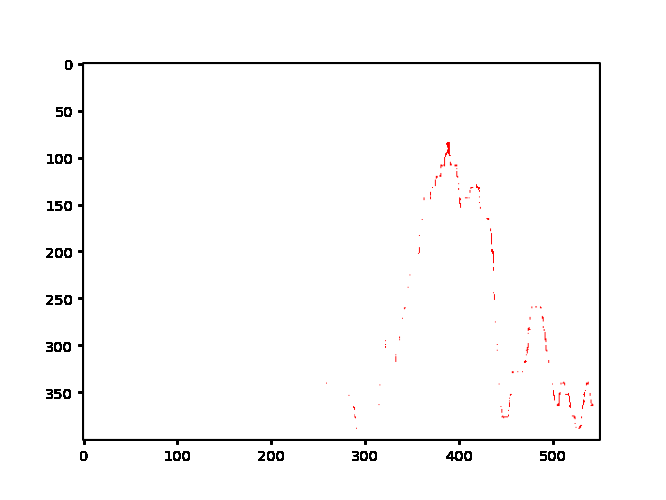

[340, 259] to [353, 283]
window 50x50 with dot in [25, 25]
Weights:[0.30814034833333337, 0.30773684749999974, 0.332747366, 0.051375438166666676]
         Value      Dist    Points   Sentido         R
1949  0.000215  0.000127  0.000051  0.000327  0.999455
2499  0.000258  0.000157  0.000074  0.000327  0.999206
1382  0.000301  0.000034  0.000044  0.000327  0.999184
[353, 283] to [365, 288]
window 50x50 with dot in [25, 25]
Weights:[0.3577352249122808, 0.20256150578947318, 0.37994800715789473, 0.0597552621403509]
        Value      Dist    Points   Sentido         R
1880  0.00012  0.000020  0.000026  0.000166  0.999588
1930  0.00012  0.000021  0.000025  0.000166  0.999586
1981  0.00012  0.000023  0.000022  0.000166  0.999582
[365, 288] to [367, 289]
window 50x50 with dot in [25, 25]
Weights:[0.10900135999999992, 0.7300488399999998, 0.14322198400000002, 0.017727816000000007]
         Value      Dist    Points   Sentido         R
1376  0.000028  0.000009  0.000006  0.000036  0.999558
1326  0

[312, 333] to [292, 337]
window 50x50 with dot in [25, 25]
Weights:[0.4062065244736842, 0.09976892223684186, 0.42607931294736845, 0.06794524034210526]
         Value      Dist    Points   Sentido         R
1325  0.000071  0.000001  0.000029  0.000000  0.999325
379   0.000249  0.000022  0.000024  0.000222  0.999191
1375  0.000178  0.000002  0.000028  0.000000  0.998973
[292, 337] to [271, 340]
window 50x50 with dot in [25, 25]
Weights:[0.4074588157017544, 0.0971132011842103, 0.4272711487368421, 0.06815683437719298]
         Value      Dist    Points   Sentido         R
1375  0.000240  0.000002  0.000026  0.000000  0.998407
1225  0.000275  0.000001  0.000025  0.000000  0.998148
2321  0.000069  0.000026  0.000032 -0.000239  0.996897
[271, 340] to [261, 342]
window 50x50 with dot in [25, 25]
Weights:[0.3136880407017544, 0.2959719136842104, 0.33802723873684215, 0.05231280687719299]
         Value      Dist    Points   Sentido         R
777   0.000325  0.000053  0.000052  0.000319  0.998914


[120, 380] to [110, 381]
window 50x50 with dot in [25, 25]
Weights:[-0.08607405166666672, 1.1437432474999998, -0.04243599400000002, -0.015233201833333265]
         Value      Dist    Points   Sentido         R
1275 -0.000047  0.000000 -0.000002 -0.000000  0.996799
776  -0.000008  0.000061 -0.000002 -0.000029  0.996173
726  -0.000016  0.000068 -0.000002 -0.000029  0.995130
[110, 381] to [105, 385]
window 50x50 with dot in [25, 25]
Weights:[0.18812157157894727, 0.5622594257894731, 0.2185225991578948, 0.031096403473684225]
         Value      Dist    Points   Sentido         R
1029  0.000011  0.000025  0.000009  0.000073  0.999898
879   0.000022  0.000034  0.000008  0.000073  0.999773
634   0.000032  0.000060  0.000010  0.000073  0.999364
[105, 385] to [97, 390]
window 50x50 with dot in [25, 25]
Weights:[0.3112316465789473, 0.30118116328947364, 0.3356894291578946, 0.05189776097368423]
        Value      Dist    Points   Sentido         R
880  0.000063  0.000024  0.000019  0.000143  0.9998

[150, 402] to [132, 414]
window 50x50 with dot in [25, 25]
Weights:[0.3081085526315789, 0.3078042763157891, 0.33271710526315784, 0.0513700657894737]
        Value      Dist    Points  Sentido         R
386  0.000041  0.000037  0.000021  0.00012  0.999740
242  0.000083  0.000048  0.000021  0.00012  0.999226
436  0.000097  0.000036  0.000021  0.00012  0.999094
[132, 414] to [134, 421]
window 50x50 with dot in [25, 25]
Weights:[0.2586828757894737, 0.4126207978947365, 0.28567749557894745, 0.04301883073684212]
         Value      Dist    Points   Sentido         R
1130  0.000083  0.000017  0.000017  0.000099  0.999395
1332  0.000097  0.000021  0.000017  0.000099  0.999169
1283  0.000097  0.000023  0.000016  0.000099  0.999158
[134, 421] to [142, 422]
window 50x50 with dot in [25, 25]
Weights:[0.3027925855263158, 0.3190777927631576, 0.32765777105263155, 0.05047185065789475]
         Value      Dist    Points   Sentido         R
1176  0.000120  0.000005  0.000019  0.000129  0.999202
1225  0.0

[183, 435] to [192, 435]
window 50x50 with dot in [25, 25]
Weights:[0.3250309455263158, 0.27191713276315765, 0.3488225550526316, 0.054229366657894754]
         Value      Dist    Points   Sentido         R
2176  0.000038  0.000124  0.000053  0.000352  0.999823
2126  0.000192  0.000117  0.000051  0.000352  0.999453
2277  0.000230  0.000138  0.000054  0.000352  0.999215
[192, 435] to [200, 437]
window 50x50 with dot in [25, 25]
Weights:[0.30337924026315793, 0.31783368013157876, 0.3282161045263158, 0.050570975078947374]
         Value      Dist    Points   Sentido         R
1726  0.000037  0.000081  0.000058  0.000351  0.999909
1676  0.000185  0.000072  0.000057  0.000351  0.999540
1827  0.000221  0.000100  0.000060  0.000351  0.999304
[200, 437] to [211, 437]
window 50x50 with dot in [25, 25]
Weights:[0.3005944389473684, 0.32373937947368403, 0.32556574189473686, 0.05010043968421053]
         Value      Dist    Points  Sentido         R
1425  0.000215  0.000024  0.000062      0.0  0.99796

[108, 392] to [109, 381]
window 50x50 with dot in [25, 25]
Weights:[0.19305420447368427, 0.5517988422368418, 0.2232171049473684, 0.03192984834210527]
         Value      Dist    Points   Sentido         R
1831  0.000057  0.000045  0.000006  0.000073  0.999339
1781  0.000079  0.000042  0.000006  0.000073  0.998974
2496  0.000034  0.000115  0.000011  0.000073  0.998248
[109, 381] to [104, 385]
window 50x50 with dot in [25, 25]
Weights:[0.20552588596491228, 0.5253502763157889, 0.23508670526315784, 0.03403713245614037]
         Value      Dist    Points   Sentido         R
1079  0.000012  0.000020  0.000010  0.000081  0.999935
929   0.000024  0.000029  0.000008  0.000081  0.999841
684   0.000036  0.000054  0.000011  0.000081  0.999546
[104, 385] to [96, 387]
window 50x50 with dot in [25, 25]
Weights:[0.32675965078947367, 0.2682510853947364, 0.35046780557894747, 0.054521458236842124]
        Value      Dist    Points   Sentido         R
930  0.000070  0.000020  0.000020  0.000156  0.999844


[106, 391] to [109, 397]
window 50x50 with dot in [25, 25]
Weights:[0.28154354526315784, 0.3641404126315786, 0.3074345465263158, 0.046881495578947385]
         Value      Dist    Points   Sentido         R
1932  0.000087  0.000043  0.000010  0.000121  0.999495
1882  0.000122  0.000041  0.000010  0.000121  0.999109
1325  0.000140  0.000003  0.000015  0.000000  0.998170
[109, 397] to [107, 385]
window 50x50 with dot in [25, 25]
Weights:[0.12218904385964911, 0.7020818552631574, 0.15577302105263163, 0.019956079824561435]
         Value      Dist    Points   Sentido         R
1776  0.000035  0.000037  0.000004  0.000044  0.999149
1726  0.000049  0.000033  0.000004  0.000044  0.998832
1827  0.000083  0.000041  0.000004  0.000044  0.996992
[107, 385] to [96, 390]
window 50x50 with dot in [25, 25]
Weights:[0.2619719209649123, 0.40564575381578916, 0.2888077592631579, 0.04357456595614037]
         Value      Dist    Points   Sentido         R
780   0.000048  0.000035  0.000015  0.000112  0.99978

[108, 385] to [126, 375]
window 50x50 with dot in [25, 25]
Weights:[0.234168687368421, 0.4646077836842104, 0.26234675073684205, 0.03887677821052635]
         Value      Dist    Points   Sentido         R
730   0.000043  0.000042  0.000013  0.000097  0.999719
676   0.000057  0.000042  0.000013  0.000097  0.999607
1838  0.000071  0.000059  0.000008  0.000097  0.999315
[126, 375] to [124, 375]
window 50x50 with dot in [25, 25]
Weights:[0.1087808785964912, 0.7305164126315784, 0.14301214652631572, 0.017690562245614078]
         Value      Dist    Points   Sentido         R
1425  0.000046  0.000014  0.000007  0.000000  0.997667
1026  0.000057  0.000024  0.000006  0.000038  0.997641
1275  0.000057  0.000000  0.000007  0.000000  0.997102
[124, 375] to [125, 375]
window 50x50 with dot in [25, 25]
Weights:[0.09927917359649106, 0.7506665801315786, 0.13396914452631586, 0.01608510174561406]
         Value      Dist    Points   Sentido         R
1126  0.000052  0.000015  0.000005  0.000035  0.997841

[143, 411] to [136, 412]
window 50x50 with dot in [25, 25]
Weights:[0.2553964126315791, 0.41959036631578916, 0.282549689263158, 0.04246353178947371]
        Value      Dist    Points   Sentido         R
727  0.000036  0.000034  0.000016  0.000097  0.999729
583  0.000073  0.000050  0.000017  0.000097  0.999151
777  0.000085  0.000031  0.000016  0.000097  0.999095
[136, 412] to [136, 422]
window 50x50 with dot in [25, 25]
Weights:[0.30305352447368417, 0.31852442223684196, 0.32790611294736854, 0.0505159403421053]
         Value      Dist   Points   Sentido         R
1076  0.000049  0.000013  0.00002  0.000126  0.999846
932   0.000099  0.000031  0.00002  0.000126  0.999361
1126  0.000115  0.000010  0.00002  0.000126  0.999198
[136, 422] to [144, 402]
window 50x50 with dot in [25, 25]
Weights:[0.31069890385964904, 0.3023109452631576, 0.33518240505263147, 0.051807745824561435]
         Value      Dist    Points   Sentido         R
1075  0.000124  0.000008  0.000020  0.000000  0.998238
1066  

[91, 390] to [86, 387]
window 50x50 with dot in [25, 25]
Weights:[0.40294433991228074, 0.10668700328947345, 0.42297461315789475, 0.0673940436403509]
         Value      Dist    Points   Sentido         R
1575  0.000167  0.000011  0.000040  0.000000  0.999360
2076  0.000444  0.000029  0.000036  0.000312  0.998948
2126  0.000500  0.000031  0.000035  0.000312  0.998659
[86, 387] to [95, 389]
window 50x50 with dot in [25, 25]
Weights:[0.37631578947368427, 0.16315789473684195, 0.3976315789473684, 0.06289473684210527]
         Value      Dist    Points   Sentido         R
1828  0.000200  0.000035  0.000048  0.000344  0.999854
1327  0.000333  0.000007  0.000044  0.000344  0.999600
1177  0.000400  0.000009  0.000039  0.000344  0.999420
[95, 389] to [93, 390]
window 50x50 with dot in [25, 25]
Weights:[0.40523987052631577, 0.10181889526315768, 0.4251593250526316, 0.06778190915789475]
         Value      Dist    Points   Sentido         R
1376  0.000135  0.000003  0.000032  0.000258  0.999857
248

[248, 438] to [249, 438]
window 50x50 with dot in [25, 25]
Weights:[0.2787358873684211, 0.37009458368421044, 0.3047624307368421, 0.046407098210526326]
         Value     Dist    Points  Sentido         R
1225  0.000123  0.00001  0.000069      0.0  0.997020
1275  0.000153  0.00000  0.000067      0.0  0.996856
1325  0.000276  0.00001  0.000065      0.0  0.995837
[249, 438] to [250, 438]
window 50x50 with dot in [25, 25]
Weights:[0.2787358873684211, 0.37009458368421044, 0.3047624307368421, 0.046407098210526326]
         Value      Dist    Points  Sentido         R
1175  0.000122  0.000021  0.000069      0.0  0.997001
1225  0.000153  0.000010  0.000067      0.0  0.996841
1275  0.000275  0.000000  0.000065      0.0  0.995826
[250, 438] to [246, 438]
window 50x50 with dot in [25, 25]
Weights:[0.27862728236842105, 0.37032490118421046, 0.3046590687368421, 0.046388747710526326]
         Value      Dist    Points  Sentido         R
1125  0.000123  0.000031  0.000069      0.0  0.997004
1175  0.00

[270, 489] to [273, 490]
window 50x50 with dot in [25, 25]
Weights:[0.40715203894736846, 0.09776377947368409, 0.4269791818947369, 0.06810499968421055]
         Value      Dist    Points   Sentido         R
2378  0.000149  0.000025  0.000033  0.000212  0.999397
2328  0.000174  0.000024  0.000033  0.000212  0.999183
2479  0.000174  0.000027  0.000035  0.000212  0.999181
[273, 490] to [286, 492]
window 50x50 with dot in [25, 25]
Weights:[0.40439440096491225, 0.10361187381578918, 0.4243546712631579, 0.06763905395614037]
         Value      Dist    Points   Sentido         R
2227  0.000141  0.000020  0.000031  0.000197  0.999400
2177  0.000165  0.000019  0.000031  0.000197  0.999187
2328  0.000165  0.000023  0.000033  0.000197  0.999185
[286, 492] to [300, 493]
window 50x50 with dot in [25, 25]
Weights:[0.36730371894736846, 0.18226969947368366, 0.3890545738947369, 0.061372007684210556]
         Value      Dist    Points   Sentido         R
1676  0.000118  0.000009  0.000026  0.000143  0.999

[358, 541] to [363, 543]
window 50x34 with dot in [25, 25]
Weights:[0.3269315139473684, 0.26788661697368377, 0.35063137189473687, 0.05455049718421054]
         Value      Dist    Points  Sentido         R
1046  0.000042  0.000012  0.000017  0.00015  0.999926
258   0.000063  0.000044  0.000016 -0.00015  0.996579
1047  0.000337  0.000013  0.000017  0.00015  0.995541
[363, 543] to [386, 530]
window 50x32 with dot in [25, 25]
Weights:[0.32960012447368414, 0.26222732223684164, 0.3531711529473684, 0.05500140034210527]
         Value      Dist    Points   Sentido         R
824   0.000044  0.000002  0.000017 -0.000145  0.997188
82    0.000066  0.000046  0.000017 -0.000145  0.997019
1548  0.000153  0.000050  0.000015 -0.000145  0.996260
[386, 530] to [366, 532]
window 39x45 with dot in [25, 25]
Weights:[0.38047610912280705, 0.15433514789473657, 0.40159105557894736, 0.06359768740350878]
         Value      Dist    Points   Sentido         R
127   0.000083  0.000039  0.000048  0.000269  0.999921


[352, 514] to [358, 518]
window 50x50 with dot in [25, 25]
Weights:[-0.152518465, 1.2846512274999995, -0.10567274599999991, -0.026460016500000016]
         Value      Dist    Points   Sentido         R
1278 -0.000072  0.000022 -0.000004 -0.000048  0.997420
1529 -0.000066  0.000047 -0.000005 -0.000048  0.997034
1275 -0.000078  0.000000 -0.000004 -0.000000  0.996176
[358, 518] to [364, 519]
window 50x50 with dot in [25, 25]
Weights:[-0.44285303342105276, 1.9003607432894731, -0.3819911628421055, -0.07551654702631577]
         Value      Dist    Points  Sentido         R
1526 -0.000175  0.000045 -0.000013 -0.00012  0.997855
1626 -0.000191  0.000062 -0.000009 -0.00012  0.997327
1549 -0.000032  0.000215 -0.000011 -0.00012  0.997116
[364, 519] to [350, 534]
window 50x50 with dot in [25, 25]
Weights:[-0.4445281955263156, 1.9039132422368419, -0.3835854550526316, -0.07579959165789474]
         Value      Dist    Points   Sentido         R
1248 -0.000034  0.000183 -0.000011 -0.000122  0.998108
13

[364, 507] to [355, 507]
window 50x50 with dot in [25, 25]
Weights:[0.25119797578947356, 0.4284939478947365, 0.2785539355789473, 0.04175414073684211]
         Value      Dist    Points   Sentido         R
2398  0.000091  0.000091  0.000011  0.000096  0.998414
1237  0.000143  0.000034  0.000014  0.000096  0.997861
936   0.000143  0.000037  0.000018  0.000096  0.997844
[355, 507] to [354, 507]
window 50x50 with dot in [25, 25]
Weights:[0.2408637876315789, 0.45040955381578884, 0.2687186392631578, 0.0400080192894737]
         Value      Dist    Points   Sentido         R
1386  0.000130  0.000044  0.000017  0.000093  0.997756
1687  0.000130  0.000056  0.000014  0.000093  0.997602
1135  0.000142  0.000041  0.000014  0.000093  0.997378
[354, 507] to [362, 507]
window 50x50 with dot in [25, 25]
Weights:[0.2392540968421053, 0.4538232084210523, 0.2671866576842106, 0.039736037052631595]
         Value      Dist    Points   Sentido         R
1436  0.000129  0.000046  0.000017  0.000092  0.997731
1

[352, 501] to [349, 501]
window 50x50 with dot in [25, 25]
Weights:[0.2737295588596491, 0.38071145276315743, 0.2999977870526315, 0.04556120132456143]
         Value      Dist    Points   Sentido         R
1880  0.000084  0.000042  0.000013  0.000113  0.999272
1681  0.000140  0.000032  0.000017  0.000113  0.998256
1731  0.000153  0.000035  0.000017  0.000113  0.997877
[349, 501] to [358, 502]
window 50x50 with dot in [25, 25]
Weights:[0.2852389389473683, 0.3563036294736839, 0.3109515418947368, 0.047505889684210545]
         Value      Dist    Points   Sentido         R
2030  0.000088  0.000052  0.000013  0.000121  0.999215
1831  0.000147  0.000041  0.000018  0.000121  0.998213
1881  0.000162  0.000044  0.000018  0.000121  0.997830
[358, 502] to [377, 523]
window 50x50 with dot in [25, 25]
Weights:[0.2902993244736841, 0.34557212223684175, 0.3157676329473685, 0.04836092034210529]
         Value      Dist    Points   Sentido         R
1579  0.000091  0.000021  0.000014  0.000119  0.999386


[342, 513] to [341, 509]
window 50x50 with dot in [25, 25]
Weights:[-0.02581398499999988, 1.0159503475, 0.014914965999999932, -0.005051328500000008]
         Value      Dist        Points  Sentido         R
1174 -0.000013  0.000012  6.003544e-07  0.00001  0.993157
1225 -0.000028  0.000005  6.456641e-07 -0.00000  0.990550
1175 -0.000027  0.000011  6.003544e-07 -0.00000  0.990115
[341, 509] to [352, 516]
window 50x50 with dot in [25, 25]
Weights:[0.2053898683333335, 0.5256387274999996, 0.23495725400000006, 0.03401415016666667]
         Value      Dist    Points   Sentido         R
1228  0.000119  0.000011  0.000012  0.000077  0.997558
2084  0.000109  0.000067  0.000014  0.000077  0.997223
1833  0.000119  0.000049  0.000011  0.000077  0.997158
[352, 516] to [356, 518]
window 50x50 with dot in [25, 25]
Weights:[-0.3437853092105265, 1.6902688453947365, -0.28770601842105265, -0.05877751776315787]
         Value      Dist    Points   Sentido         R
1527 -0.000140  0.000046 -0.000012 -0.000

[329, 458] to [352, 455]
window 50x50 with dot in [25, 25]
Weights:[0.4070250494736842, 0.0980330847368418, 0.4268583229473685, 0.06808354284210527]
        Value      Dist    Points   Sentido         R
688  0.000125  0.000015  0.000038  0.000204  0.999741
687  0.000219  0.000015  0.000038  0.000204  0.999200
140  0.000282  0.000024  0.000034  0.000204  0.998653
[352, 455] to [352, 456]
window 50x50 with dot in [25, 25]
Weights:[0.3923577652631579, 0.1291378426315788, 0.41289911452631584, 0.0656052775789474]
         Value      Dist    Points  Sentido         R
1275  0.000075  0.000000  0.000025  0.00000  0.999031
1276  0.000225  0.000001  0.000025  0.00018  0.998656
128   0.000250  0.000025  0.000032  0.00018  0.998322
[352, 456] to [329, 457]
window 50x50 with dot in [25, 25]
Weights:[0.3923577652631579, 0.1291378426315788, 0.41289911452631584, 0.0656052775789474]
       Value      Dist    Points   Sentido         R
127  0.00025  0.000024  0.000032  0.000183  0.998323
126  0.00025  0

[310, 472] to [287, 474]
window 50x50 with dot in [25, 25]
Weights:[0.39291078763157894, 0.12796505381578904, 0.41342543926315783, 0.0656987192894737]
        Value      Dist    Points   Sentido         R
926  0.000000  0.000007  0.000033  0.000188  0.999998
827  0.000053  0.000009  0.000032  0.000188  0.999935
395  0.000160  0.000025  0.000026  0.000188  0.999404
[287, 474] to [284, 474]
window 50x50 with dot in [25, 25]
Weights:[0.39265399263157896, 0.12850963631578916, 0.41318104126315797, 0.0656553297894737]
         Value      Dist    Points   Sentido         R
1543  0.000144  0.000018  0.000028  0.000187  0.999411
1493  0.000167  0.000017  0.000028  0.000187  0.999196
1644  0.000167  0.000019  0.000030  0.000187  0.999195
[284, 474] to [272, 476]
window 50x50 with dot in [25, 25]
Weights:[0.36850767684210517, 0.17971647842105232, 0.3902004096842105, 0.06157543505263159]
         Value      Dist    Points   Sentido         R
1693  0.000129  0.000023  0.000023  0.000164  0.999397
1

[376, 452] to [369, 453]
window 49x50 with dot in [25, 25]
Weights:[0.3593197518421053, 0.19920121592105233, 0.38145603968421055, 0.06002299255263159]
         Value      Dist    Points   Sentido         R
78    0.000122  0.000090  0.000042  0.000305  0.999770
79    0.000365  0.000090  0.000042  0.000305  0.998574
1226  0.000405  0.000005  0.000043  0.000305  0.998331
[369, 453] to [364, 454]
window 50x50 with dot in [25, 25]
Weights:[0.3883658465789474, 0.13760346328947337, 0.4090999091578948, 0.06493078097368424]
        Value      Dist    Points   Sentido         R
427  0.000108  0.000042  0.000038  0.000281  0.999824
428  0.000323  0.000043  0.000038  0.000281  0.998632
976  0.000359  0.000015  0.000041  0.000281  0.998330
[364, 454] to [370, 446]
window 50x50 with dot in [25, 25]
Weights:[0.4014136715789474, 0.10993307578947353, 0.4215178391578948, 0.06713541347368424]
         Value      Dist    Points   Sentido         R
676   0.000098  0.000021  0.000036  0.000249  0.999839
677

In [251]:
%matplotlib notebook
R=list()
P,W=pathing(A_hsv,center,pesos=[1/4,1/4,1/4,1/4],max_it=500)

In [252]:
w=pd.DataFrame(W,columns=['Value','Distancia','Densidad','Sentido'])
b=pd.DataFrame(P[1:])
b=pd.concat([w,b],axis=1)
b['R']=R
b.sort_values(1,inplace=True)
b.reset_index(drop=True,inplace=True)

(0.0, 550.0)

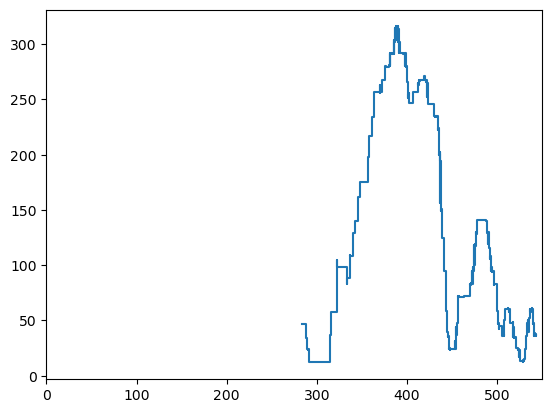

In [253]:
%matplotlib inline
#plt.plot(b['R'])
plt.step(b[1],400-b[0],where='post')
plt.xlim(0,550)

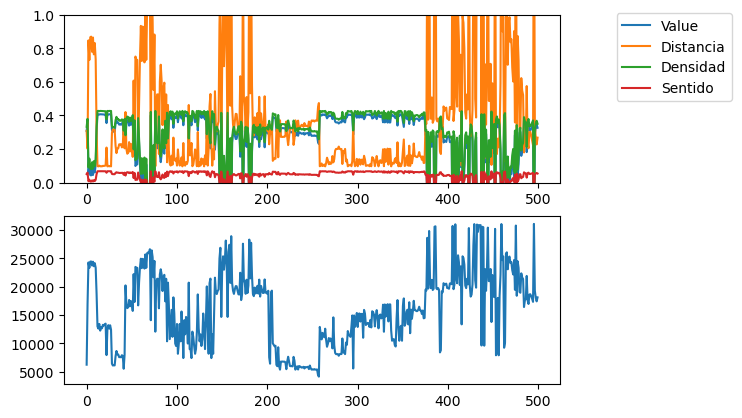

In [254]:
fig,ax=plt.subplots(2,1)
ax[0].plot(b[['Value','Distancia','Densidad','Sentido']])
ax[0].set_ylim(0,1)
ax[0].legend(['Value','Distancia','Densidad','Sentido'],bbox_to_anchor=(1.1, 1.05))
ax[1].plot(b['R'])